In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/ubuntu/sustaingym


In [2]:
!ls

LICENSE    algo_comp_2021.png  env_norl.yml	 examples   sustaingym
README.md  env.yml	       epsiode_plot.png  notebooks


In [ ]:
%run examples/train -y 2019 -v 2021 -a -m PPO -l 0.0001 -o examples

In [ ]:
%run examples/train -y 2021 -a -m PPO -l 0.0001 -o examples

In [ ]:
%run examples/train -y 2019 -v 2021 -a -d -m DQN -l 0.0001 -o examples

In [ ]:
%run examples/train -y 2021 -a -d -m DQN -l 0.0001 -o examples

In [ ]:
%run examples/train -y 2019 -v 2021 -a -d -m A2C -l 0.0001 -o examples

In [3]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.callbacks import EvalCallback, CallbackList, StopTrainingOnNoModelImprovement
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv



from sustaingym.envs import ElectricityMarketEnv
from sustaingym.envs.battery.plot_utils import *
from sustaingym.envs.battery.wrapped import DiscreteActions
from sustaingym.evaluate.run_electricitymarket import *

/home/ubuntu/.conda/envs/sustaingym/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


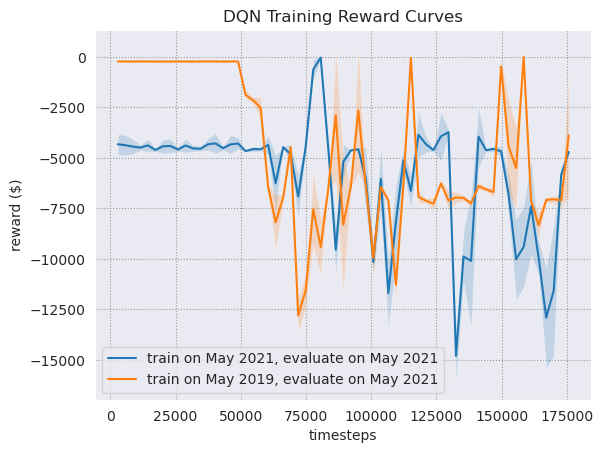

In [4]:
ax = plot_model_training_reward_curves(None, 'DQN', ['examples/DQN_discrete_2019_g0.9999_lr0.0001', 'examples/DQN_discrete_2021_g0.9999_lr0.0001'], ['in_dist', 'out_dist'], 2021, 2019)
plt.savefig('examples/ppo_reward_curves.png', dpi=300)

/home/ubuntu/.conda/envs/sustaingym/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/ubuntu/.conda/envs/sustaingym/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


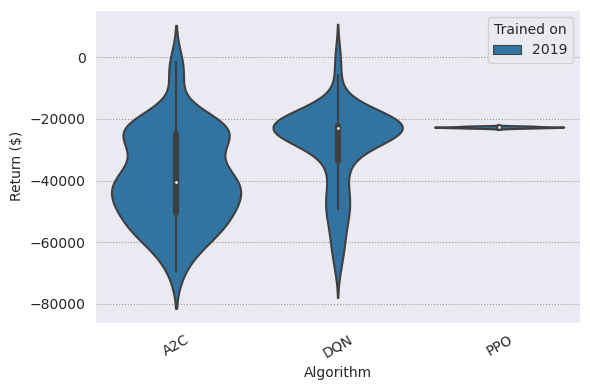

In [5]:
A2C_res = np.load('examples/A2C_discrete_2019_g0.9999_lr0.0001/eval2019-05/evaluations.npz')
DQN_res = np.load('examples/DQN_discrete_2019_g0.9999_lr0.0001/eval2019-05/evaluations.npz')
PPO_res = np.load('examples/PPO_2019_g0.9999_lr0.0001/eval2019-05/evaluations.npz')

ax = plot_returns({"A2C (2019)": A2C_res, "DQN (2019)": DQN_res, "PPO (2019)": PPO_res})

plt.xticks(rotation=30)

plt.savefig('algo_comp_2021.png', dpi=300)

In [12]:
import datetime
import gym
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

# df_load = pd.read_csv('sustaingym/data/demand_data/CAISO-demand-2019-05.csv.gz', compression='gzip', index_col=0)

# env = ElectricityMarketEnv(month='2019-05', seed=195)
# discrete_env = DiscreteActions(env)

# a2c = A2C.load('examples/A2C_discrete_2019_g0.9999_lr0.0001/model.zip')

# ax, ax2 = plot_state_of_charge_and_prices(None, df_load, a2c, 'a2c in-dist', discrete_env)

# plt.savefig('prices_and_soc_over_episode.png', dpi=300)

NameError: name 'plot_state_of_charge_and_prices' is not defined

In [ ]:
# env = ElectricityMarketEnv(month='2019-05', seed=195)
# env = DiscreteActions(env)
# ppo = PPO.load('examples/PPO_2019_g0.9999_lr0.0001/model.zip')

# ax, ax2 = plot_reward_over_episode(None, ppo, env)

# plt.savefig('reward_over_epsiode.png', dpi=300)

In [8]:
env = ElectricityMarketEnv(month='2019-05', seed=195)

# run offline optimal
env.reset(seed=0)
results = run_offline_optimal(seeds=[0], env=env)
dispatch = results['dispatch']
offline_data = {
    'rewards': results['rewards'][0],
    'prices': results['prices'][0],
    'model_name': 'offline',
    'energy_level': results['energy'][0]
}

# run follow optimal deterministic model
env.reset(seed=0)
follow_rewards, follow_energy, follow_prices = run_follow_offline_optimal(seeds=[0],
                                                env=env, opt_dispatches=dispatch, opt_energies=results['energy'])
follow_offline_data = {
    'rewards': follow_rewards[0],
    'prices': follow_prices[0],
    'model_name': 'follow offline',
    'energy_level': follow_energy[0]
}

# run PPO model
env.reset(seed=0)
ppo = PPO.load('examples/PPO_2019_g0.9999_lr0.0001/model.zip')
ppo_results = run_model(ppo, [0], env, False)

ppo_data = {
    'rewards': ppo_results['rewards'][0],
    'prices': ppo_results['prices'][0],
    'model_name': 'ppo',
    'energy_level': ppo_results['energy'][0],
    'bids': ppo_results['actions'][0]
}

# run DQN model

env.reset(seed=0)
dqn = DQN.load('examples/DQN_discrete_2019_g0.9999_lr0.0001/model.zip')
dqn_results = run_model(dqn, [0], env, True)

dqn_data = {
    'rewards': dqn_results['rewards'][0],
    'prices': dqn_results['prices'][0],
    'model_name': 'ppo',
    'energy_level': dqn_results['energy'][0]
}

fig, axs, times = setup_episode_plot(env, '2019-05', include_bids=True)
plot_episode(axs, times, **offline_data)
plot_episode(axs, times, **follow_offline_data)
plot_episode(axs, times, **ppo_data)
plot_episode(axs, times, **dqn_data)

for ax in axs:
    ax.legend()

plt.savefig('epsiode_plot.png', dpi=300)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

TypeError: 'int' object is not subscriptable